In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.impute import SimpleImputer
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from pathlib import Path
from scipy.stats import skew 


In [2]:
data_dir = './input/'
# data_dir = Path("../input/house-prices-advanced-regression-techniques/")
X_train = pd.read_csv(data_dir + 'train.csv', index_col="id")
X_test = pd.read_csv(data_dir + 'test.csv', index_col="id")

## EDA (Exploratory Data Analysis)

hasil :
### missing values :
Missing values:
- Guest_Popularity_percentage    (146030) (19%)
- Episode_Length_minutes          (87093) (12%)
- Number_of_Ads                       (1)

In [3]:
def explore_data(df):
    print(f"DataFrame shape: {df.shape}")
    print(f"DataFrame columns: {df.columns.tolist()}")
    print(f"DataFrame info:\n{df.info()}")
    print(f"DataFrame description:\n{df.describe(include='all')}")
    print(f"Missing values:\n{df.isnull().sum().sort_values(ascending=False).head(20)}")
    print(f"Duplicate rows: {df.duplicated().sum()}")

In [4]:
explore_data(X_train)

DataFrame shape: (750000, 11)
DataFrame columns: ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Listening_Time_minutes']
<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads    

In [112]:
X_train

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Episode_Sentiment,Listening_Time_minutes,Episode_Number,Number_of_Ads_log
id,,,,,,,,,,,
0,Mystery Matters,0.00,True Crime,74.81,Thursday,Night,0.00,Positive,31.41998,98.0,0.000000
1,Joke Junction,119.80,Comedy,66.95,Saturday,Afternoon,75.95,Negative,88.01241,26.0,1.098612
2,Study Sessions,73.90,Education,69.97,Tuesday,Evening,8.97,Negative,44.92531,16.0,0.000000
3,Digital Digest,67.17,Technology,57.22,Monday,Morning,78.70,Positive,46.27824,45.0,1.098612
4,Mind & Body,110.51,Health,80.07,Monday,Afternoon,58.68,Neutral,75.61031,86.0,1.386294
...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,75.66,Education,69.36,Saturday,Morning,0.00,Negative,56.87058,25.0,0.000000
749996,Business Briefs,75.75,Business,35.21,Saturday,Night,0.00,Neutral,45.46242,21.0,1.098612
749997,Lifestyle Lounge,30.98,Lifestyle,78.58,Thursday,Morning,84.89,Negative,15.26000,51.0,0.000000


## Preprocessing

beberapa funtion untuk preprocessing :

- clean() - potensi regex
- encode() 
- impute() - masih bisa dikembangin
- outlier_check()


In [3]:
# disini bisa buat fitur episode_number
def clean(df):

    df['Episode_Number'] = df['Episode_Title'].str.extract(r'(\d+)').astype(float)
    df = df.drop('Episode_Title', axis=1)

    return df

    

In [4]:
def encode(df):
    # The nominative (unordered) categorical features
    features_nom = [
    'Podcast_Name',
    'Genre',
    'Publication_Day',
    ]
    
    features_ord = ['Episode_Sentiment', 'Publication_Time']

    ordered_levels = {
        'Episode_Sentiment': ['Negative', 'Neutral', 'Positive'],
        'Publication_Time': ['Morning', 'Afternoon', 'Evening', 'Night']
    }

    # Add a None level for missing values
    ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

    
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    
    return df
    

In [5]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def impute_upgraded(df):
    for name in df.select_dtypes("number").columns:
        df[name] = df[name].fillna(df[name].median())
    for name in df.select_dtypes("category").columns:
        df[name] = df[name].fillna(df[name].mode().iloc[0])  # mode bisa punya banyak nilai
    return df

def impute_fillna_mean(df):
    # numerical features
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(df[name].mean())
    
    # categorical features
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna(df[name].mode().iloc[0])

    return df


def impute_fillna_median(df):
    # numerical features
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(df[name].median())
 
    # categorical features
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna(df[name].mode().iloc[0])

    return df


def impute_simple_mean(df):
    #numerical features
    num_features = df.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='mean')
    df[num_features] = num_imputer.fit_transform(df[num_features])

    #categorical features
    cat_features = df.select_dtypes(include=['object', 'category']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_features] = cat_imputer.fit_transform(df[cat_features])

    for col in cat_features:
        df[col] = df[col].astype('category').cat.codes

    return df   

def impute_simple_median(df):
    #numerical features
    num_features = df.select_dtypes(include=['int64', 'float64']).columns
    imputer = SimpleImputer(strategy='median')
    df[num_features] = imputer.fit_transform(df[num_features])

    #categorical features
    cat_features = df.select_dtypes(include=['object', 'category']).columns
    imputer = SimpleImputer(strategy='most_frequent')
    df[cat_features] = imputer.fit_transform(df[cat_features])

    for col in cat_features:
        df[col] = df[col].astype('category').cat.codes
    return df 


In [6]:
def outlier_check(df, feature, log=False, return_filtered=False, q_low=0.01, q_high=0.99, plot=True):

    # Menampilkan grafik distribusi fitur jika plot=True
    if plot:
        print(f"📊 Distribusi Fitur: {feature}")
        plt.figure(figsize=(12, 4))
        sns.histplot(df[feature], bins=100, kde=True, color='skyblue')
        plt.title(f'Distribusi asli: {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frekuensi')
        plt.show()

        if log:
            plt.figure(figsize=(12, 4))
            sns.histplot(np.log1p(df[feature]), bins=100, kde=True, color='salmon')
            plt.title(f'Distribusi log(1 + {feature})')
            plt.xlabel(f"log(1 + {feature})")
            plt.ylabel('Frekuensi')
            plt.show()

    # Menghitung quantile
    ql = df[feature].quantile(q_low)
    qh = df[feature].quantile(q_high)

    if plot:
        print(f"🔍 Quantile batas:")
        print(f" - {int(q_low*100)}th percentile: {ql:.2f}")
        print(f" - {int(q_high*100)}th percentile: {qh:.2f}")

    # Filter data berdasarkan quantile
    df_filtered = df[(df[feature] >= ql) & (df[feature] <= qh)]
    if plot:
        print(f"✅ Jumlah data setelah filter: {df_filtered.shape[0]} dari {df.shape[0]} ({100 * df_filtered.shape[0] / df.shape[0]:.2f}%)")
    
    print("Sisa data:", df_filtered.shape)
    
    # Mengembalikan hasil filter jika return_filtered=True
    if return_filtered:
        return df_filtered  # Hanya mengembalikan data yang sudah difilter


📊 Distribusi Fitur: Episode_Length_minutes


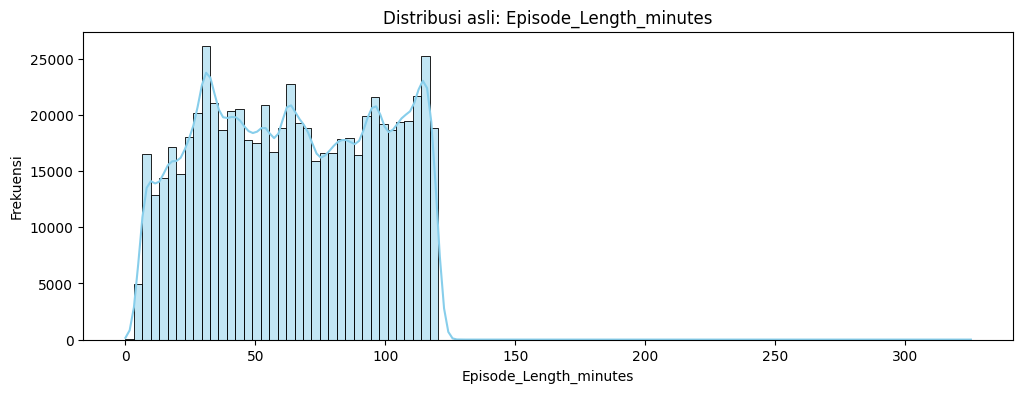

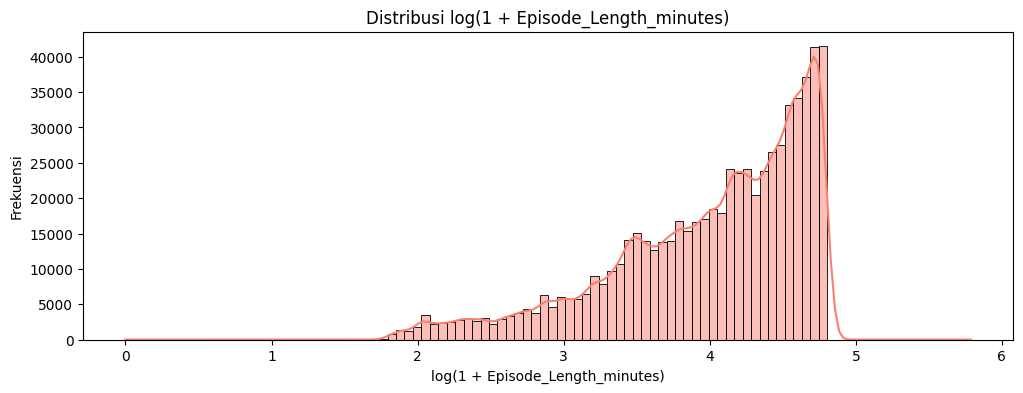

🔍 Quantile batas:
 - 1th percentile: 6.69
 - 99th percentile: 119.02
✅ Jumlah data setelah filter: 649853 dari 750000 (86.65%)
Sisa data: (649853, 11)


In [10]:
df_noOutlier = outlier_check(X_train, 'Episode_Length_minutes', log=True, return_filtered=True)

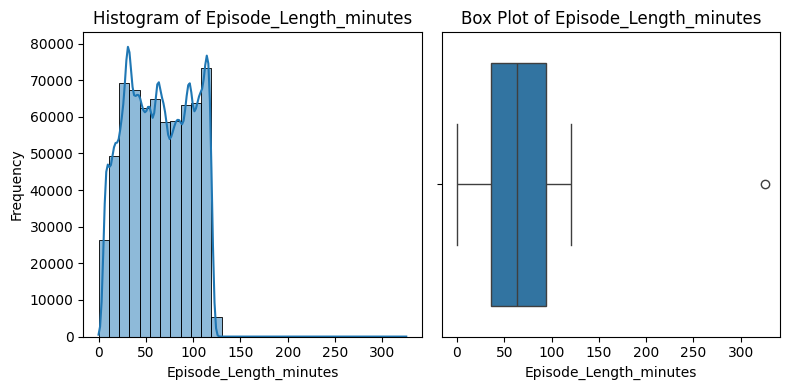


Statistics for Episode_Length_minutes:
Skewness: -0.00


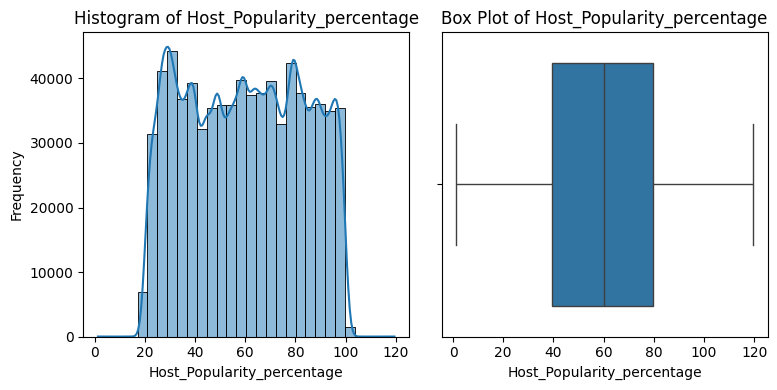


Statistics for Host_Popularity_percentage:
Skewness: 0.00


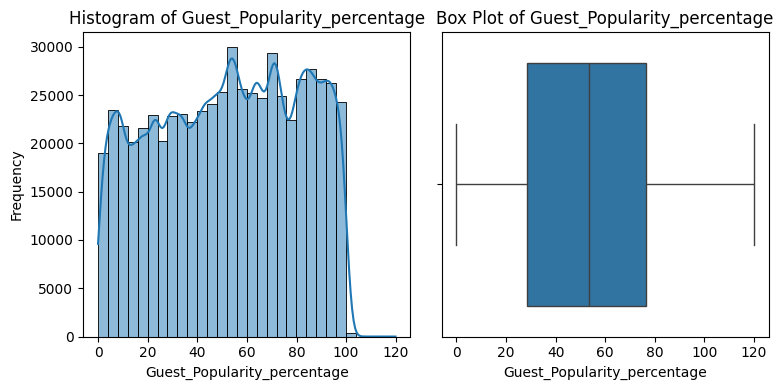


Statistics for Guest_Popularity_percentage:
Skewness: -0.11


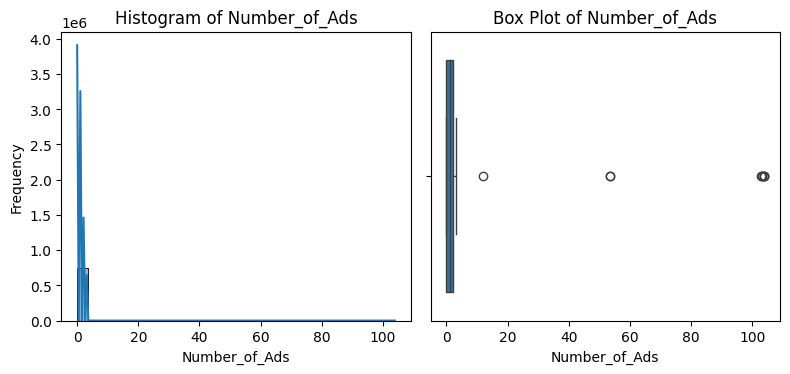


Statistics for Number_of_Ads:
Skewness: 6.03


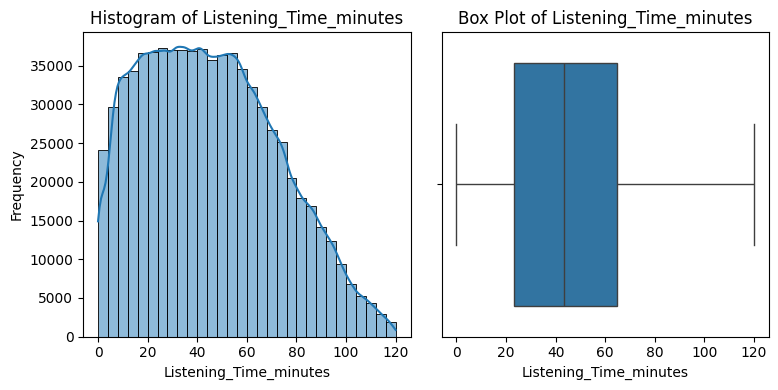


Statistics for Listening_Time_minutes:
Skewness: 0.35


In [25]:
def skewness():
    df_train = pd.read_csv(data_dir + 'train.csv', index_col="id")
    return df_train

numerical_features = [
        "Episode_Length_minutes",
        "Host_Popularity_percentage",
        "Guest_Popularity_percentage",
        "Number_of_Ads",
        "Listening_Time_minutes",
    ]

df_train = skewness()

for feature in numerical_features:
    plt.figure(figsize=(8, 4))

    # Histogram with KDE (Kernel Density Estimate)
    plt.subplot(1, 2, 1)
    sns.histplot(df_train[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

    # Box plot to identify outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_train[feature])
    plt.title(f"Box Plot of {feature}")

    plt.tight_layout()
    plt.show()

    # Print additional statistics
    print(f"\nStatistics for {feature}:")
    print(f"Skewness: {df_train[feature].skew():.2f}")

## Load Data

- load_data()
- panggil load_data()

In [35]:
def load_data():
    #Read data
    data_dir = 'input/'
    # data_dir = Path("../input/house-prices-advanced-regression-techniques/")

    df_train = pd.read_csv(data_dir + 'train.csv', index_col="id")
    df_test = pd.read_csv(data_dir + 'test.csv', index_col="id")

    #Merge the splits so we can preprocess them together
    df = pd.concat([df_train, df_test])
    #Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute_upgraded(df)

    df['is_weekend'] = df['Publication_Day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)


    #reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]

    # df_train = outlier_check(df_train, 'Episode_Length_minutes', log=True, return_filtered=True, plot=False)


    return df_train, df_test

def load_data_for_baseLine():
    data_dir = 'input/'

    df_train = pd.read_csv(data_dir + 'train.csv', index_col="id")
    df_test = pd.read_csv(data_dir + 'test.csv', index_col="id")

    # Simpan panjang data asli untuk df_train dan df_test
    train_len = len(df_train)
    test_len = len(df_test)

    # Gabungkan df_train dan df_test
    df = pd.concat([df_train, df_test])

    # Preprocessing
    df = clean(df)
    df = encode(df)
    #df = impute_fillna_median(df)
    #df = impute_upgraded(df)
    df = impute(df)

    # df['is_weekend'] = df['Publication_Day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

    
    # df['Number_of_Ads_log'] = np.log1p(df['Number_of_Ads'])
    # df['Guest_Popularity_percentage_log'] = np.log1p(df['Guest_Popularity_percentage'])
    # df['Host_Popularity_percentage_log'] = np.log1p(df['Host_Popularity_percentage'])
    # df['Episode_Length_minutes_log'] = np.log1p(df['Episode_Length_minutes']) 
    
    # df = df.drop(columns=['Number_of_Ads'])
    # df = df.drop(columns=['Guest_Popularity_percentage'])
    # df = df.drop(columns=['Host_Popularity_percentage'])
    # df = df.drop(columns=['Episode_Length_minutes'])
    

    # Pisahkan kembali df_train dan df_test berdasarkan panjang data asli
    df_train = df.iloc[:train_len, :]
    df_test = df.iloc[train_len:train_len + test_len, :]

    # df_train = outlier_check(df_train, 'Episode_Length_minutes', log=True, return_filtered=True, plot=False)



    return df_train, df_test

## Base line

- score_dataset()
- cek liat score

Baseline : 13.20727 RMSE

In [30]:
df_train, df_test = load_data_for_baseLine()

In [31]:
df_train

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Number
id,,,,,,,,,,,
0,Mystery Matters,0.00,True Crime,74.81,Thursday,Night,0.00,0.0,Positive,31.41998,98.0
1,Joke Junction,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,26.0
2,Study Sessions,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,16.0
3,Digital Digest,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,45.0
4,Mind & Body,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,86.0
...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,75.66,Education,69.36,Saturday,Morning,0.00,0.0,Negative,56.87058,25.0
749996,Business Briefs,75.75,Business,35.21,Saturday,Night,0.00,2.0,Neutral,45.46242,21.0
749997,Lifestyle Lounge,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000,51.0


In [9]:
xgb_params = {
    'random_state': 0,
    'n_estimators': 565,
    'max_depth': 14,
    'learning_rate': 0.04222221,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,    
    'tree_method':'hist', 
    # 'tree_method':'gpu_hist', 
    'n_jobs': -1  
}

#xgbmodel
xgb_model = XGBRegressor(
    random_state = 0,
    n_estimators = 565,
    max_depth= 14,
    learning_rate = 0.04222221,
    subsample= 0.8,
    colsample_bytree = 0.8,   
    n_jobs= -1 
)

#lgbmodel
lgbm_model = LGBMRegressor(
        random_state = 0,
        n_iter=1000,
        max_depth=-1,
        num_leaves=1024,
        colsample_bytree=0.7,
        learning_rate=0.03,
        objective='l2',
        verbosity=-1,
        max_bin=1024,
)

In [32]:
def score_dataset(X, y, model=XGBRegressor(random_state=0)):
    # Label encoding for categoricals
    for colname in X.select_dtypes("category"):
        X[colname] = X[colname].cat.codes
    
    # Cross-validation pakai RMSE
    score = cross_val_score(
        model, X, y, 
        cv=5,
        scoring="neg_mean_squared_error"
    )

    score = -1 * score.mean()
    score = np.sqrt(score)  #matriknya make rmse
    return score


X = df_train.copy()
y = X.pop("Listening_Time_minutes")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSE")


Baseline score: 13.20727 RMSE


In [ ]:
#Baseline With KFold

from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def score_dataset_Kfold(X,y, X_test):

    X = X.copy()
    X_test = X_test.copy()
    
    for colname in X.select_dtypes("category"):
        X[colname] = X[colname].cat.codes
        
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    test_preds = np.zeros(len(X_test))


    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Training fold {fold + 1}/{n_splits}...")    
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]   
        model = XGBRegressor()
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)    
        val_pred = model.predict(X_val)
        score = rmse(y_val, val_pred)
        scores.append(score)
        test_preds += model.predict(X_test) / n_splits      
        print(f"Fold {fold + 1} RMSE: {score:.4f}")

    print(f'Optimized Cross-validated RMSE score: {np.mean(scores):.5f} +/- {np.std(scores):.5f}')
    print(f'Max RMSE score: {np.max(scores):.5f}')
    print(f'Min RMSE score: {np.min(scores):.5f}')

    return test_preds

In [34]:
X = df_train.copy()
y = X.pop("Listening_Time_minutes")
X_test = df_test.copy()
X_test = X_test.drop(columns=["Listening_Time_minutes"], errors='ignore')  # drop kalau ada

pred =score_dataset_Kfold(X, y, X_test)

Training fold 1/5...
[0]	validation_0-rmse:21.27552
[99]	validation_0-rmse:13.17871
Fold 1 RMSE: 13.1787
Training fold 2/5...
[0]	validation_0-rmse:21.31154
[99]	validation_0-rmse:13.23970
Fold 2 RMSE: 13.2397
Training fold 3/5...
[0]	validation_0-rmse:21.28973
[99]	validation_0-rmse:13.21385
Fold 3 RMSE: 13.2138
Training fold 4/5...
[0]	validation_0-rmse:21.34162
[99]	validation_0-rmse:13.21245
Fold 4 RMSE: 13.2124
Training fold 5/5...
[0]	validation_0-rmse:21.24788
[99]	validation_0-rmse:13.19319
Fold 5 RMSE: 13.1932
Optimized Cross-validated RMSE score: 13.20758 +/- 0.02066
Max RMSE score: 13.23970
Min RMSE score: 13.17872


## Feature Engineering
Hasil experiment :

### Improve
- cluster_labels : naik dari 13.20727 jadi 13.20711 RMSE
- Feature TopFeaturesCombined : Improvement: 0.179172
- Feature GuestImpact : Improvement: 0.149887
- Feature HostImpact : Improvement: 0.146457
- Feature ContentDensity : Improvement: 0.138797
- Impute median : naik dari 13.20727 jadi 13.03053 RMSE 
- Model Tuning : naik dari 13.20727 jadi 12.82695 RMSE
- simpleImputer : naik dari jadi 13.20727 13.03053 RMSE


### Degrade
- pca_components : turun dari 13.20727 jadi 13.226382669875116
- Feature PopularityScore : Improvement: -0.006710
- Feature PopularityScore : Improvement: -0.006710
- Feature EngagementFactor : Improvement: -0.004424
- Feature PodcastMomentum : Improvement: -0.005147
- Feature TimeDayInteraction : Improvement: -0.001016
- remove outlier malah turun

### No Change
- NormalizedEpisodeNumber : Improvement: 0.000000
- Skew fix: Number_of_Ads, Guest_Popularity_percentage, Host_Popularity_percentage, Episode_Length_minutes : Improvement : 0

In [11]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [12]:
X = df_train.copy()
y = X.pop("Listening_Time_minutes")

In [ ]:
mi_scores = make_mi_scores(X, y)
print("Mutual Information Scores:")
mi_scores

Mutual Information Scores:


Episode_Length_minutes         2.036795
Host_Popularity_percentage     0.762879
Episode_Number                 0.684967
Guest_Popularity_percentage    0.642437
Podcast_Name                   0.416703
Publication_Day                0.243486
Number_of_Ads                  0.238516
Genre                          0.199015
Publication_Time               0.175717
Episode_Sentiment              0.141619
Name: MI Scores, dtype: float64

In [13]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

### K-means clustering


In [14]:
#K-means clustering

cluster_features = [
    "Episode_Length_minutes",
    "Host_Popularity_percentage",
    "Guest_Popularity_percentage",
    "Episode_Number"
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)               #TUNING
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)                          #TUNING
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [16]:
df_cluster_labels= cluster_labels(X, cluster_features, n_clusters=20)
df_cluster_distance = cluster_distance(X, cluster_features, n_clusters=20)


In [17]:
df_cluster = pd.concat([df_cluster_labels, df_cluster_distance], axis=1)
df_cluster

,Cluster,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,...,Centroid_10,Centroid_11,Centroid_12,Centroid_13,Centroid_14,Centroid_15,Centroid_16,Centroid_17,Centroid_18,Centroid_19
0,4,3.010509,3.801805,2.675283,4.198374,1.095845,3.475447,3.436084,2.818004,2.390641,...,3.650241,3.181609,3.899121,2.588240,4.455128,2.650650,2.929395,3.503088,3.981208,2.997944
1,3,2.529697,2.341916,3.070589,1.042411,3.728678,1.442270,2.617002,2.414838,3.271104,...,2.180995,3.579887,2.778544,2.833784,1.505014,3.435151,3.457286,2.055932,2.438948,3.005558
2,0,0.725581,3.274965,2.488198,2.091364,2.551230,1.934345,2.354384,2.813671,3.225522,...,0.863819,2.054970,2.699921,2.240856,2.444670,1.634921,3.585258,3.041642,1.593313,2.559241
3,7,2.082159,1.565732,1.680886,1.399368,2.774114,1.315598,1.687282,1.072365,2.017074,...,2.526541,2.689302,1.572775,2.623289,1.243629,2.749193,1.898600,1.770163,2.390555,2.496301
4,17,2.957881,2.058777,3.114015,2.317026,2.747770,1.523643,3.174929,1.811516,2.465993,...,2.629491,4.059833,3.688819,1.573364,2.916852,3.590782,3.041665,0.745708,3.235470,2.385243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,0,0.736149,3.239798,2.492015,2.329851,2.346262,1.904994,2.584864,2.812198,3.227213,...,0.872966,2.077963,2.908934,1.963311,2.624907,1.684936,3.570354,3.019756,1.568173,2.306133
749996,18,1.369815,2.994310,2.259039,3.029721,3.098090,2.235229,3.217213,3.143920,3.869008,...,2.207560,1.534696,2.615924,2.852226,2.254656,2.585217,3.385310,3.707668,0.625952,2.021478
749997,6,2.513306,2.625111,2.019938,1.843862,2.418177,2.291827,1.029959,1.219751,1.032841,...,2.924369,3.068736,2.014941,2.890066,2.548381,2.438910,2.067192,1.965703,3.417059,3.327369
749998,14,2.950753,1.332297,2.688974,1.925889,3.830063,1.580241,2.912088,2.012460,3.132711,...,3.100579,3.582609,2.476409,3.152024,1.166306,3.910079,2.662740,2.091837,2.616036,2.725935


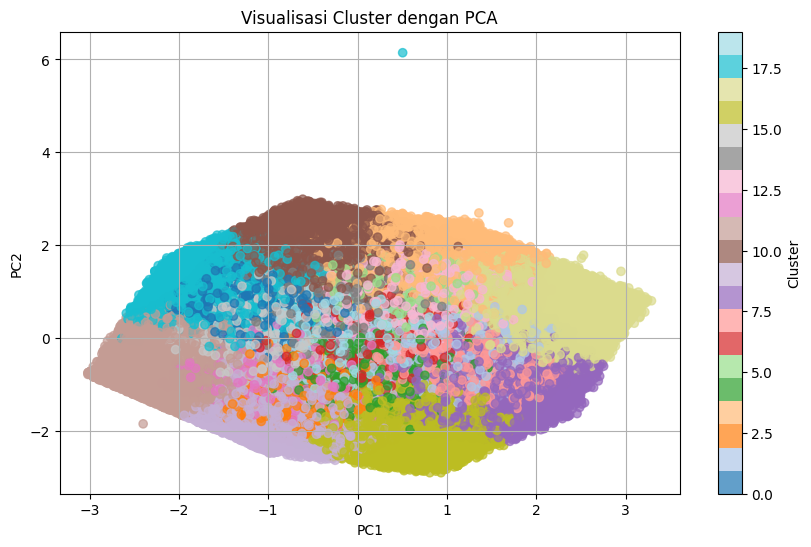

In [18]:
from sklearn.preprocessing import StandardScaler

# Scaling ulang agar cocok untuk PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[cluster_features])

# PCA untuk reduksi ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Gabungkan hasil PCA dan label cluster
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_cluster['Cluster']

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='tab20', alpha=0.7)
plt.title('Visualisasi Cluster dengan PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

### PCA (Principal Component Analysis)

- pca_components()
- pca_inspired()

In [36]:
#Principal Component Analysis

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


#gabung-gabungin feature dari analysis PCA
def pca_inspired(df):
    X = pd.DataFrame()
    X["TopFeaturesCombined"] = df.Episode_Length_minutes * df.Host_Popularity_percentage * df.Episode_Number
    X["GuestImpact"] = df.Guest_Popularity_percentage * df.Episode_Length_minutes
    X["HostImpact"] = df.Host_Popularity_percentage * df.Episode_Length_minutes
    X["ContentDensity"] = df.Episode_Length_minutes / (df.Number_of_Ads + 1)
    return X

def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

pca_features = [
    "Episode_Length_minutes",         # MI tinggi
    "Host_Popularity_percentage",
    "Guest_Popularity_percentage",
    "Episode_Number",
    "Number_of_Ads"
]

def create_features_categorical(df):
    df['is_weekend'] = df['Publication_Day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

    return df


In [20]:
X_pca = pca_components(X, pca_features)
X_pca

,PC1,PC2,PC3,PC4,PC5
0,0.119857,1.103150,1.108162,-1.692417,-1.790341
1,-0.959265,-0.789147,-0.228006,1.402177,1.256861
2,-0.326783,-1.845508,0.545230,-0.718242,-0.235128
3,-0.253083,0.311175,-0.570820,0.551576,0.955160
4,-0.765062,1.025744,0.869273,2.053519,0.243862
...,...,...,...,...,...
749995,-0.278269,-1.735690,0.688885,-0.625619,-0.604618
749996,1.318441,-1.474102,-0.236746,0.685685,-0.332938
749997,-1.240113,0.535334,-0.204157,-1.369580,0.698668
749998,-1.826873,-0.497569,-1.554102,0.379491,0.167730


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

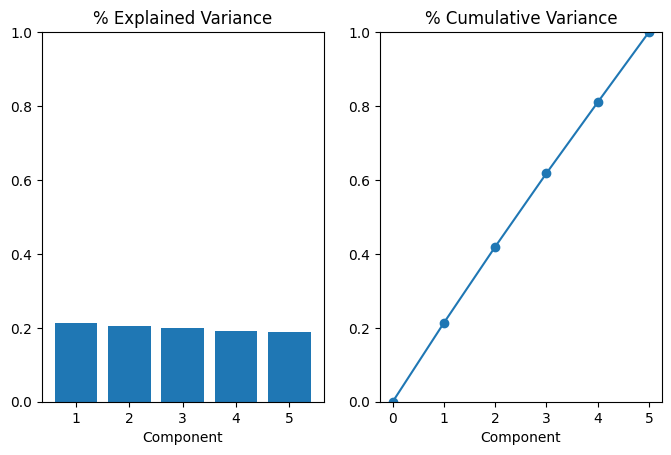

In [21]:
df_pca = X.loc[:, pca_features]
pca, X_pca, loadings = apply_pca(df_pca)
plot = plot_variance(pca)
plot

#### Mencari Feature terbaik dari untuk pca_inspired()

Baseline XGBoost MSRE: 13.207268 ± 1.076183
- With PopularityScore: MSRE = 13.213978 ± 1.090161 (Improvement: -0.006710)
- With HostImpact: MSRE = 13.060811 ± 0.914555 (Improvement: 0.146457)
- With GuestImpact: MSRE = 13.057381 ± 1.046029 (Improvement: 0.149887)
- With NormalizedEpisodeNumber: MSRE = 13.207268 ± 1.076183 (Improvement: 0.000000)
- With EngagementFactor: MSRE = 13.211691 ± 1.118318 (Improvement: -0.004424)
- With PodcastMomentum: MSRE = 13.212414 ± 1.069311 (Improvement: -0.005147)
- With TimeDayInteraction: MSRE = 13.208284 ± 1.060503 (Improvement: -0.001016)
- With ContentDensity: MSRE = 13.068470 ± 1.030627 (Improvement: 0.138797)
- With TopFeaturesCombined: MSRE = 13.028096 ± 0.956762 (Improvement: 0.179172)


In [22]:

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


# Fungsi custom untuk menghitung MSRE (Mean Squared Relative Error)
def msre(y_true, y_pred):
    """
    Mean Squared Relative Error: mean((y_true - y_pred)^2 / y_true^2)
    """
    # Hindari pembagian dengan 0
    mask = y_true != 0
    y_true_safe = y_true[mask]
    y_pred_safe = y_pred[mask]
    
    if len(y_true_safe) == 0:
        return 0.0
    
    # Hitung MSRE
    relative_errors = ((y_true_safe - y_pred_safe) ** 2) / (y_true_safe ** 2)
    return np.mean(relative_errors)

# Buat scorer untuk digunakan dalam cross_val_score
msre_scorer = make_scorer(msre, greater_is_better=False)

def evaluate_xgb_features(df, target_col, features_list, params=None):

    results = {}    
    
    # Baseline model dengan fitur asli
    X_baseline = df.drop(target_col, axis=1)
    baseline_features = X_baseline.columns.tolist()
    y = df[target_col]
    
    # Evaluasi baseline dengan XGBoost
    model = XGBRegressor()
    baseline_scores = cross_val_score(model, X_baseline, y, cv=5, scoring='neg_mean_squared_error')
    # Negasikan karena make_scorer menghasilkan -MSRE untuk greater_is_better=False
    baseline_msre = -np.mean(baseline_scores)
    baseline_msre = np.sqrt(baseline_msre)
    
    results['baseline'] = {
        'msre': baseline_msre,
        'std': np.std(-baseline_scores),
        'features_used': baseline_features
    }
    
    print(f"Baseline XGBoost MSRE: {baseline_msre:.6f} ± {np.std(-baseline_scores):.6f}")
    
    # Buat dan evaluasi setiap fitur baru secara individual
    for feature_name, feature_func in features_list.items():
        try:
            # Buat fitur baru
            new_feature = feature_func(df)
            
            if isinstance(new_feature, pd.Series):
                new_feature = pd.DataFrame({feature_name: new_feature})
            
            # Gabungkan dengan fitur baseline
            X_combined = pd.concat([X_baseline, new_feature], axis=1)
            
            # Evaluasi dengan XGBoost dan cross-validation
            model = XGBRegressor()
            scores = cross_val_score(model, X_combined, y, cv=5, scoring='neg_mean_squared_error')
            msre_value = -np.mean(scores)  # Negasikan untuk mendapatkan actual MSRE
            msre_value = np.sqrt(msre_value) 
            
            # Simpan hasil
            results[feature_name] = {
                'msre': msre_value,
                'std': np.std(-scores),
                'improvement': baseline_msre - msre_value,  # Positive means better (lower MSRE)
                'features_used': X_combined.columns.tolist()
            }
            
            print(f"With {feature_name}: MSRE = {msre_value:.6f} ± {np.std(-scores):.6f} " +
                  f"(Improvement: {baseline_msre - msre_value:.6f})")
            
        except Exception as e:
            print(f"Error evaluating {feature_name}: {str(e)}")
    
    return results

def plot_xgb_feature_results(results):
    """
    Visualisasi hasil evaluasi fitur
    """
    features = list(results.keys())
    msre_values = [results[f]['msre'] for f in features]
    improvements = [results[f]['improvement'] if f != 'baseline' else 0 for f in features]
    
    # Sort by improvement (descending)
    sorted_indices = np.argsort([-imp for imp in improvements])
    sorted_features = [features[i] for i in sorted_indices]
    sorted_improvements = [improvements[i] for i in sorted_indices]
    
    plt.figure(figsize=(12, 8))
    colors = ['green' if imp > 0 else 'red' for imp in sorted_improvements]
    bars = plt.barh(sorted_features, sorted_improvements, color=colors)
    
    plt.xlabel('MSE Improvement (Positive is better)')
    plt.title('Feature Importance by MSE Improvement')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    # Tambahkan nilai di setiap bar
    for i, bar in enumerate(bars):
        value = sorted_improvements[i]
        plt.text(value + 0.0001 if value >= 0 else value - 0.005, 
                 bar.get_y() + bar.get_height()/2, 
                 f'{value:.6f}', 
                 va='center')
    
    plt.tight_layout()
    
    return plt


# Definisikan fitur yang akan diuji
pca_inspired_features = {
    "PopularityScore": lambda df: df.Host_Popularity_percentage * df.Guest_Popularity_percentage,
    
    "HostImpact": lambda df: df.Host_Popularity_percentage * df.Episode_Length_minutes,
    
    "GuestImpact": lambda df: df.Guest_Popularity_percentage * df.Episode_Length_minutes,
    
    "NormalizedEpisodeNumber": lambda df: df.Episode_Number / df.groupby('Podcast_Name')['Episode_Number'].transform('max'),
    
    "EngagementFactor": lambda df: df.Host_Popularity_percentage + df.Guest_Popularity_percentage + (df.Episode_Sentiment * 100),
    
    "PodcastMomentum": lambda df: df.Episode_Number * df.Host_Popularity_percentage,
    
    "TimeDayInteraction": lambda df: df.Publication_Time + (df.Publication_Day * 24),
    
    "ContentDensity": lambda df: df.Episode_Length_minutes / (df.Number_of_Ads + 1),
    
    "TopFeaturesCombined": lambda df: df.Episode_Length_minutes * df.Host_Popularity_percentage * df.Episode_Number
}

Baseline XGBoost MSRE: 13.207268 ± 1.076183
With PopularityScore: MSRE = 13.213978 ± 1.090161 (Improvement: -0.006710)
With HostImpact: MSRE = 13.060811 ± 0.914555 (Improvement: 0.146457)
With GuestImpact: MSRE = 13.057381 ± 1.046029 (Improvement: 0.149887)
With NormalizedEpisodeNumber: MSRE = 13.207268 ± 1.076183 (Improvement: 0.000000)
With EngagementFactor: MSRE = 13.211691 ± 1.118318 (Improvement: -0.004424)
With PodcastMomentum: MSRE = 13.212414 ± 1.069311 (Improvement: -0.005147)
With TimeDayInteraction: MSRE = 13.208284 ± 1.060503 (Improvement: -0.001016)
With ContentDensity: MSRE = 13.068470 ± 1.030627 (Improvement: 0.138797)
With TopFeaturesCombined: MSRE = 13.028096 ± 0.956762 (Improvement: 0.179172)


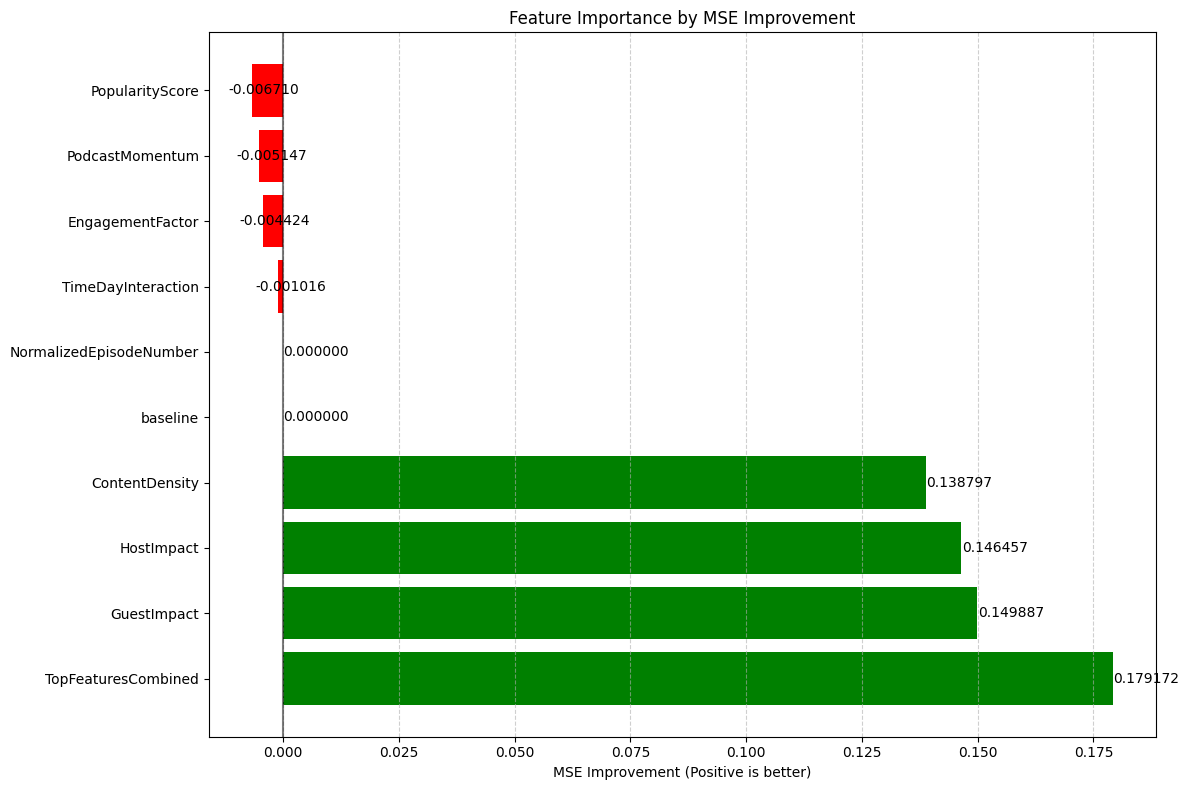

In [26]:

df_train, df_test = load_data_for_baseLine()
df_train = label_encode(df_train)
results = evaluate_xgb_features(df_train, 'Listening_Time_minutes', pca_inspired_features)
plot = plot_xgb_feature_results(results)
plot.show()

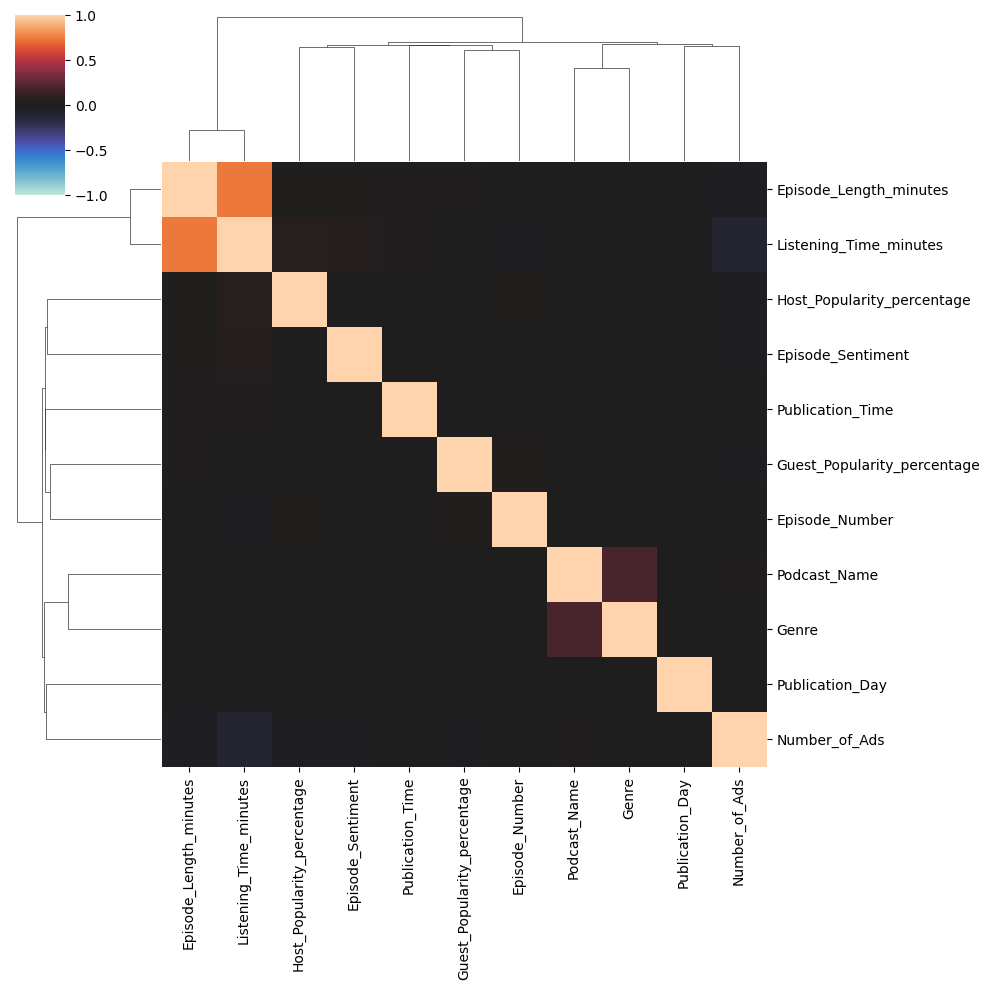

In [27]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

## Train & Predict

In [37]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("Listening_Time_minutes")

    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("Listening_Time_minutes")
        X = pd.concat([X, X_test])

    X = create_features_categorical(X)
    X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(pca_components(X, pca_features))
    X = X.join(pca_inspired(X))

    X = label_encode(X)
    
    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    
    if df_test is not None:
        return X, X_test
    else:
        return X


### Evaluasi hasil create features

In [38]:
df_train, df_test = load_data()
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:,'Listening_Time_minutes']


In [39]:
X_train

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Episode_Number,is_weekend,Cluster,TopFeaturesCombined,GuestImpact,HostImpact,ContentDensity
id,,,,,,,,,,,,,,,,
0,34,63.87,9,74.81,4,4,53.54,0.0,3,98.0,0,12,468255.2406,3419.5998,4778.1147,63.870000
1,24,119.80,1,66.95,2,2,75.95,2.0,1,26.0,1,17,208535.8600,9098.8100,8020.6100,39.933333
2,40,73.90,2,69.97,5,3,8.97,0.0,1,16.0,0,1,82732.5280,662.8830,5170.7830,73.900000
3,10,67.17,8,57.22,1,1,78.70,2.0,3,45.0,0,3,172956.0330,5286.2790,3843.4674,22.390000
4,31,110.51,3,80.07,1,2,58.68,3.0,2,86.0,0,12,760974.0702,6484.7268,8848.5357,27.627500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,26,75.66,2,69.36,2,1,53.54,0.0,1,25.0,1,15,131194.4400,4050.8364,5247.7776,75.660000
749996,2,75.75,0,35.21,2,4,53.54,2.0,2,21.0,1,4,56010.3075,4055.6550,2667.1575,25.250000
749997,28,30.98,4,78.58,4,1,84.89,0.0,1,51.0,0,3,124154.8284,2629.8922,2434.4084,30.980000


In [40]:
print(f"Final Score : {score_dataset(X_train, y_train, model=XGBRegressor(**xgb_params)):.5f} RMSE")

Final Score : 12.66665 RMSE


### Train model

In [ ]:
# xgb = XGBRegressor(**xgb_params)

# xgb.fit(X_train, y_train)
# y_pred = xgb.predict(X_test)


In [41]:
xgb = XGBRegressor(**xgb_params)
y_pred =score_dataset_Kfold(X_train, y_train, X_test)

Training fold 1/5...
[0]	validation_0-rmse:21.21907
[99]	validation_0-rmse:13.00896
Fold 1 RMSE: 13.0090
Training fold 2/5...
[0]	validation_0-rmse:21.25365
[99]	validation_0-rmse:13.05656
Fold 2 RMSE: 13.0566
Training fold 3/5...
[0]	validation_0-rmse:21.23280
[99]	validation_0-rmse:13.04644
Fold 3 RMSE: 13.0464
Training fold 4/5...
[0]	validation_0-rmse:21.28465
[99]	validation_0-rmse:13.05305
Fold 4 RMSE: 13.0530
Training fold 5/5...
[0]	validation_0-rmse:21.18469
[99]	validation_0-rmse:13.01345
Fold 5 RMSE: 13.0134
Optimized Cross-validated RMSE score: 13.03569 +/- 0.02030
Max RMSE score: 13.05656
Min RMSE score: 13.00896


## Submission


In [42]:
def make_submisson():
    output = pd.DataFrame({'id': X_test.index, 'Listening_Time_minutes': y_pred})
    output.to_csv('my_submission6_Kfoldd.csv', index=False)
    print("Your submission was successfully saved!")

In [43]:
# make_submisson()

Your submission was successfully saved!


## Next Upcoming Experiment


2. Text Features:
Panjang judul episode (len(Episode_Title)), jumlah kata, apakah mengandung kata clickbait?
Vectorization dari Episode_Title (TF-IDF atau embeddings ringan)

3. 📊 Modeling
Coba model non-tree seperti Ridge/Lasso, SVR, atau bahkan Neural Net ringan
Model ensemble: blend 2–3 model yang performanya beda
Stacking: gunakan prediksi dari beberapa model sebagai input ke meta-mode

5.  Group-wise Imputation:
Imputasi Episode_Length_minutes atau Guest_Popularity_percentage per Genre atau per Podcast_Name, bukan global median.

7. 🧠 NLP-lite dari Episode_Title
Length features: jumlah kata, karakter, panjang rata-rata kata
Clickbait check: apakah mengandung kata-kata seperti “amazing”, “shocking”, “you won’t believe”, angka (Top 5, 10 tips)
TF-IDF atau countvectorizer (top 100 kata) → XGB bisa handle ini langsung

8. Interaksi Genre x TimeOfDay → genre tertentu perform lebih bagus pagi/malam?

9. Coba k-means clustering untuk Podcast_Name → beri cluster ID sebagai feature